#Goal of lab:
1. Generate and manipulate signals
2. Visualize signals
3. Save signals to listen to them 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from mpl_toolkits.mplot3d import Axes3D #For 3d plots
import winsound
#from mlp

In [3]:
2/3.0

0.6666666666666666

## Q1: Sampling of a sinusoid

In [4]:
'''Auxiliary functions'''
def float_to_16BitInt(yFloat):
    y_16bit_int = [int(s*32767) for s in yFloat]
    return np.array(y_16bit_int, dtype= 'int16')

def int16bit_to_float(y_16bit_int):
    yFloat = [float(s/32767.0) for s in y_16bit_int]
    return np.array(yFloat, dtype = 'float')
    

'''Create continous time sinusiod'''
def continousTimeSinusoid(A, signal_freq, phase_phi, freq_sampling, start_time, end_time):
    '''Output: sample_instant, time_instant, amplitude '''
    
    #how do we generate a continous time signal -> this won't be possible as that would mean infinite values
    #this is just the cos / sine function with some phase shift
    #Acos(2*pi*f*t + phi)
    #so we generate the samples we need based on sampling frequency
    
    time_steps = np.arange(start_time, end_time, 1.0/freq_sampling) #Step size in time duration = 1/sampling frequency
    time_steps = time_steps.reshape(time_steps.shape[0],1)
    sample_step = np.arange(0,time_steps.shape[0]).reshape(time_steps.shape[0],1)
    cont_signal = A*np.cos(2*np.pi*signal_freq*time_steps + phase_phi)
    concatenated_tensor = np.concatenate((sample_step, time_steps, cont_signal), axis =1)
    return concatenated_tensor

def sketch_signal(x,y, x_label="Sample time", y_label="Sample amplitude", scatter = True, grid = True):
    plt.figure(1)
   
    plt.plot(x,y)
    if(scatter):
        plt.scatter(x,y)
    plt.title("Sampled Signal")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if(grid):
        plt.grid()
    #plt.show()
    return plt

In [5]:
q3_1 = continousTimeSinusoid(10, 1000, 0, 16000, 0, 0.5)

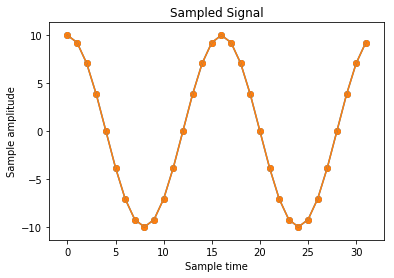

In [8]:
sketch_signal(q3_1[:32,0],q3_1[:32,2], scatter=True).show()

In [85]:
q3_1[:10,0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

## Q2: DTMF Signal

In [66]:
def gen_mapping_dict(items, rows, columns):
    ptr = 0 
    mapping_dict = {}
    for row_tone in rows:
        if(ptr>=len(items)):
            break
        for column_tone in columns:
            mapping_dict[items[ptr]] = [row_tone, column_tone]
            ptr+=1
    return mapping_dict

def gen_DTMFseq(code, mapping_dict, time = 1, amp =1, sampling_freq = 1600): 
    '''
    A DTMF sequence consists of two frequencies -> dual tone multi frequency
    '''
    codes = list(code)
    tones = []
    prev_time = 0 
    prev_sample = 0
    time_period = 1/sampling_freq
    
    for code in codes:
        freqs = mapping_dict[code]
        sinusoid1 = continousTimeSinusoid(1, freqs[0], 0, sampling_freq, 0, time)
        sinusoid2 = continousTimeSinusoid(1, freqs[1], 0, sampling_freq, 0, time)
        
        #The time and sample instants are same for both; also track previous time step since next tone is a continuation 
        resulting_sinusoid_sample = sinusoid1[:,0] + prev_sample
        resulting_sinusoid_time = sinusoid1[:,1] + prev_time
     
        prev_sample = resulting_sinusoid_sample[-1] + 1
        
        prev_time = resulting_sinusoid_time[-1] + time_period
        
        resulting_sinusoid_amp =  sinusoid1[:,2] + sinusoid2[:,2] #Adding only amplitudes
        tones.append([resulting_sinusoid_sample, resulting_sinusoid_time, resulting_sinusoid_amp])
    return tones
        
columns = [1209, 1336, 1477]
rows = [697, 770, 852, 941]
items = list(range(1,10)) + ['*',0,'#']
items = list(map(lambda x: str(x), items))
mapping_dict = gen_mapping_dict(items, rows, columns)
mapping_dict

{'#': [941, 1477],
 '*': [941, 1209],
 '0': [941, 1336],
 '1': [697, 1209],
 '2': [697, 1336],
 '3': [697, 1477],
 '4': [770, 1209],
 '5': [770, 1336],
 '6': [770, 1477],
 '7': [852, 1209],
 '8': [852, 1336],
 '9': [852, 1477]}

In [67]:
1/1600

0.000625

In [68]:
gen_DTMFseq('123', mapping_dict)

[[array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
           1.59700000e+03,   1.59800000e+03,   1.59900000e+03]),
  array([  0.00000000e+00,   6.25000000e-04,   1.25000000e-03, ...,
           9.98125000e-01,   9.98750000e-01,   9.99375000e-01]),
  array([ 2.        , -0.88397158, -0.30725156, ..., -0.45562885,
         -0.30725156, -0.88397158])],
 [array([ 1600.,  1601.,  1602., ...,  3197.,  3198.,  3199.]),
  array([ 1.      ,  1.000625,  1.00125 , ...,  1.998125,  1.99875 ,
          1.999375]),
  array([ 2.        , -0.41026573,  0.20849757, ..., -1.34930521,
          0.20849757, -0.41026573])],
 [array([ 3200.,  3201.,  3202., ...,  4797.,  4798.,  4799.]),
  array([ 2.      ,  2.000625,  2.00125 , ...,  2.998125,  2.99875 ,
          2.999375]),
  array([ 2.        , -0.03371077,  1.25881309, ..., -0.2283624 ,
          1.25881309, -0.03371077])]]

In [44]:
list("*123")

['*', '1', '2', '3']

## Q4: Discrete time polar signal

In [89]:
1j**2

(-1+0j)

In [9]:
def gen_discrete_time_polar_signal(A, omega, phase_shift, start_sample_n, end_sample_n, breakdown_by_sinusoids_as_well = False):
    '''(Ae^(i(angle)))^n
    
    Output: [[complex sample, complex rep]] 
    '''
    samples = np.arange(start_sample_n, end_sample_n)
    samples = samples.reshape(samples.shape[0],1)
    
    magnitude = np.power(A, samples)
    
    signal = np.multiply(magnitude, np.exp(1j*(omega*samples + phase_shift)))
    
    concatentated_tensor = np.concatenate((samples, signal), axis =1)
    
    if(breakdown_by_sinusoids_as_well):
        exp_real_val = magnitude*np.cos(omega*samples + phase_shift)#cosine
        exp_img_val = magnitude*np.sin(omega*samples + phase_shift) #sin

        assert exp_real_val[len(exp_real_val)-5]== signal[len(exp_real_val)-5].real
        assert exp_img_val[len(exp_real_val)-5] == signal[len(exp_real_val)-5].imag #This can fail for different precisions
        concatentated_tensor_using_sinusoidbreakdown = np.concatenate((samples, exp_real_val, exp_img_val), axis =1)
        return concatentated_tensor, concatentated_tensor_using_sinusoidbreakdown
        
    #coordinate_tuple = n, magnitude*exp_real_val, magnitude*exp_img_val
    return concatentated_tensor

def plot_2d_dtps(sample_steps, complex_rep = None, cos_thet= None, sin_thet = None, fig_size = (10,8)):
    plt.figure(2, figsize = fig_size)
    num_samples = len(sample_steps)
    
    if(complex_rep.shape[0]>0):
        plt.plot(sample_steps, complex_rep[0:num_samples].real, 'r--o')
        plt.plot(sample_steps, complex_rep[0:num_samples].imag, 'g--o')
    elif(cos_thet.shape[0]>0 and sin_thet.shape[0]>0):
        plt.plot(sample_steps, cos_thet[0:num_samples], 'r--o')
        plt.plot(sample_steps, sin_thet[0:num_samples], 'g--o')
    plt.xlabel('sample index')
    plt.ylabel('y[n]')
    plt.title("Complex exponential (read=real; green=imag)")
    plt.grid()
    return plt

def plot_polar_dtps(sample_steps, complex_rep = None, fig_size = (10,8)):
    plt.figure(3, figsize= fig_size)
    num_samples = len(sample_steps)
    for complex_var in complex_rep:
        plt.polar([0, np.angle(complex_var)],[0, np.abs(complex_var)], marker = 'o')
        
    plt.title("Polar plot showing phasors at n = 0...{}".format(num_samples))
    return plt

def plot_3d_complex_plane(sample_steps, complex_rep = None, fig_size = (10,8)):
    plt.rcParams['legend.fontsize'] = 10
    fig = plt.figure(4, figsize=fig_size)
    num_samples = len(sample_steps)
    ax = fig.gca(projection = '3d') #create 3d axis for complex imag
    real_val = complex_rep[0:num_samples].real
    imag_val = complex_rep[0:num_samples].imag
    ax.plot(sample_steps, real_val, imag_val, label = 'complex_exp_phasor')
    ax.scatter(sample_steps, real_val, imag_val, c ='r', marker = 'o')
    ax.set_xlabel('sample n')
    ax.set_ylabel('real')
    ax.set_zlabel('imag')
    ax.legend()
    return plt

In [13]:
complex_vars = gen_discrete_time_polar_signal(0.95, np.pi/18, 0, 0, 50, False)
complex_vars[:10]

array([[  0.00000000e+00+0.j        ,   1.00000000e+00+0.j        ],
       [  1.00000000e+00+0.j        ,   9.35567365e-01+0.16496577j],
       [  2.00000000e+00+0.j        ,   8.48072590e-01+0.30867318j],
       [  3.00000000e+00+0.j        ,   7.42508531e-01+0.4286875j ],
       [  4.00000000e+00+0.j        ,   6.23947987e-01+0.52355453j],
       [  5.00000000e+00+0.j        ,   4.97376799e-01+0.59275059j],
       [  6.00000000e+00+0.j        ,   3.67545945e-01+0.63660825j],
       [  7.00000000e+00+0.j        ,   2.38845422e-01+0.6562224j ],
       [  8.00000000e+00+0.j        ,   1.15201749e-01+0.65334158j],
       [  9.00000000e+00+0.j        ,   3.85916461e-17+0.63024941j]])

In [12]:
complex_to_real_int = lambda x: list(map(lambda l: int(l.real), x))
samples_in_int = complex_to_real_int(complex_vars[: , 0])
plt2d = plot_2d_dtps(samples_in_int, complex_vars[:,1])
plt_polar = plot_polar_dtps(samples_in_int, complex_vars[:,1])
plt_3d = plot_3d_complex_plane(samples_in_int, complex_vars[:,1])

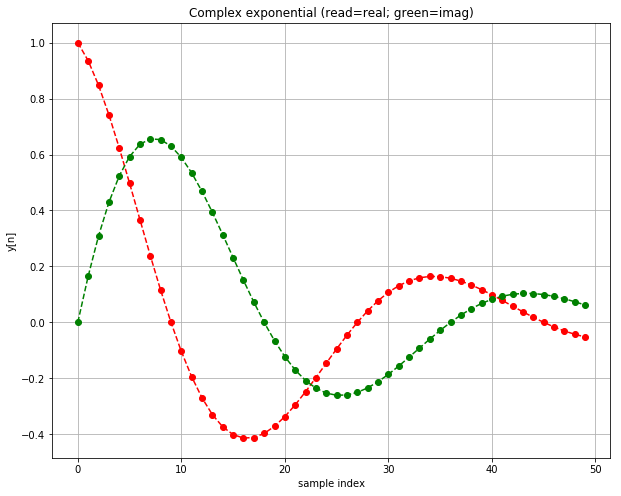

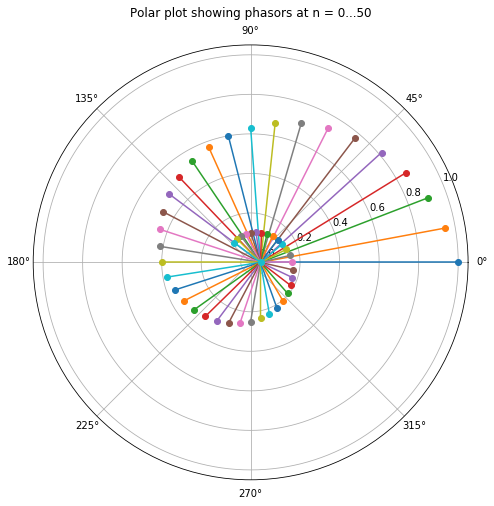

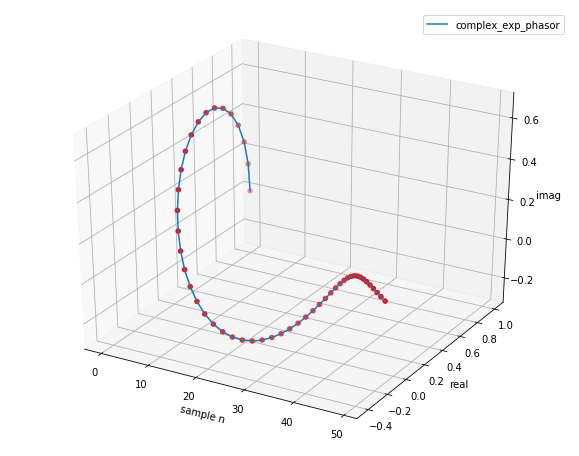

In [14]:
plt2d.show()
plt_polar.show()
plt_3d.show()

## Q5: Unit amplitude signal with differing frequencies (k)

In [16]:
def gen_W_signal(k, start_n, end_n):
    samples = np.arange(start_n, end_n)
    N = samples.shape[0]
    samples = samples.reshape(N,1)
    exp_real_val = np.cos(2*np.pi*k*samples/N)
    exp_img_val = np.sin(2*np.pi*k*samples/N)
    concatenated_tensor = np.concatenate((samples, exp_real_val, exp_img_val), axis =1)
    return concatenated_tensor

In [20]:
complex_vars = gen_W_signal(1, 0, 16) #k=1

#Relevant plots
complex_to_real_int = lambda x: list(map(lambda l: int(l.real), x))
samples_in_int = complex_to_real_int(complex_vars[: , 0])
plt2d = plot_2d_dtps(samples_in_int, complex_vars[:,1])
plt_polar = plot_polar_dtps(samples_in_int, complex_vars[:,1])
plt_3d = plot_3d_complex_plane(samples_in_int, complex_vars[:,1])
complex_vars[:10]

array([[  0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   9.23879533e-01,   3.82683432e-01],
       [  2.00000000e+00,   7.07106781e-01,   7.07106781e-01],
       [  3.00000000e+00,   3.82683432e-01,   9.23879533e-01],
       [  4.00000000e+00,   6.12323400e-17,   1.00000000e+00],
       [  5.00000000e+00,  -3.82683432e-01,   9.23879533e-01],
       [  6.00000000e+00,  -7.07106781e-01,   7.07106781e-01],
       [  7.00000000e+00,  -9.23879533e-01,   3.82683432e-01],
       [  8.00000000e+00,  -1.00000000e+00,   1.22464680e-16],
       [  9.00000000e+00,  -9.23879533e-01,  -3.82683432e-01]])

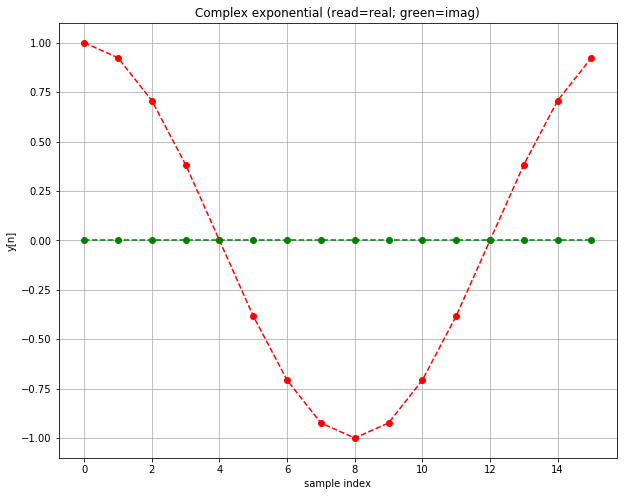

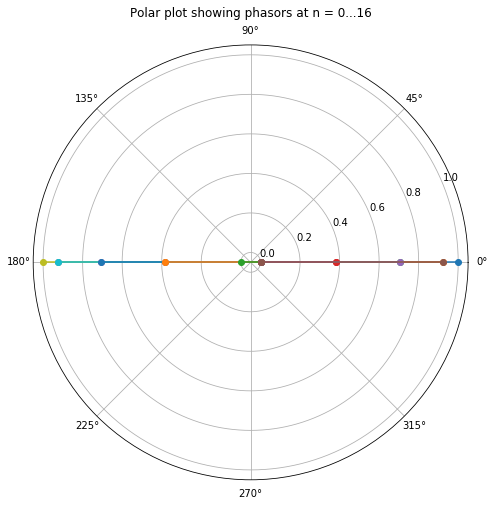

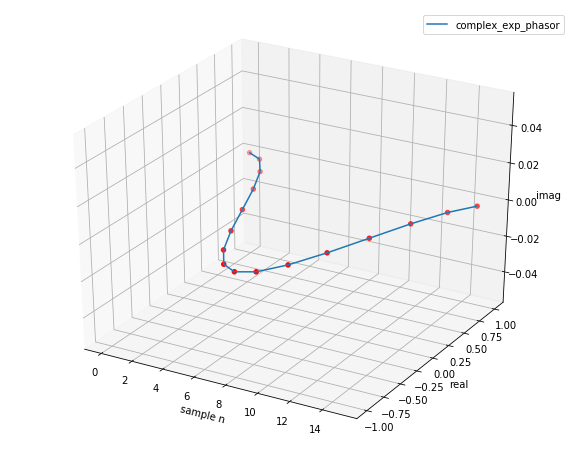

In [21]:
plt2d.show()
plt_polar.show()
plt_3d.show()

In [22]:
complex_vars = gen_W_signal(2, 0, 16) #k=2

#Relevant plots
complex_to_real_int = lambda x: list(map(lambda l: int(l.real), x))
samples_in_int = complex_to_real_int(complex_vars[: , 0])
plt2d = plot_2d_dtps(samples_in_int, complex_vars[:,1])
plt_polar = plot_polar_dtps(samples_in_int, complex_vars[:,1])
plt_3d = plot_3d_complex_plane(samples_in_int, complex_vars[:,1])
complex_vars[:10]

array([[  0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   7.07106781e-01,   7.07106781e-01],
       [  2.00000000e+00,   6.12323400e-17,   1.00000000e+00],
       [  3.00000000e+00,  -7.07106781e-01,   7.07106781e-01],
       [  4.00000000e+00,  -1.00000000e+00,   1.22464680e-16],
       [  5.00000000e+00,  -7.07106781e-01,  -7.07106781e-01],
       [  6.00000000e+00,  -1.83697020e-16,  -1.00000000e+00],
       [  7.00000000e+00,   7.07106781e-01,  -7.07106781e-01],
       [  8.00000000e+00,   1.00000000e+00,  -2.44929360e-16],
       [  9.00000000e+00,   7.07106781e-01,   7.07106781e-01]])

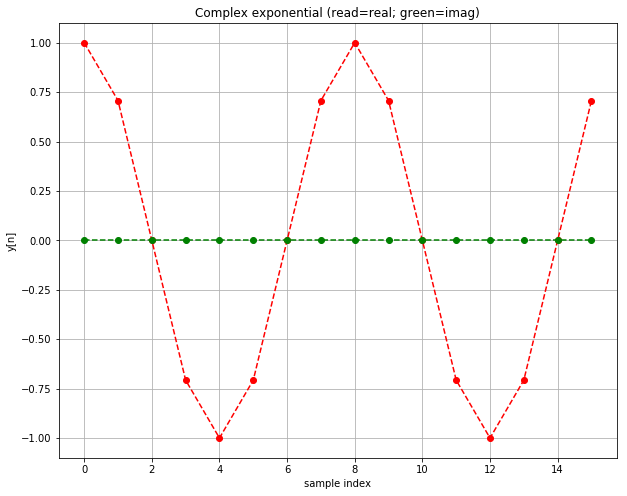

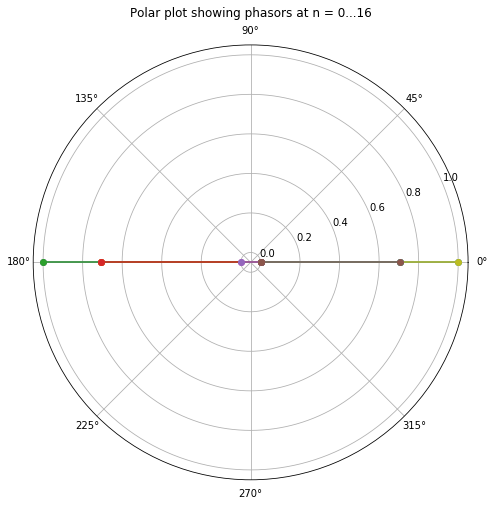

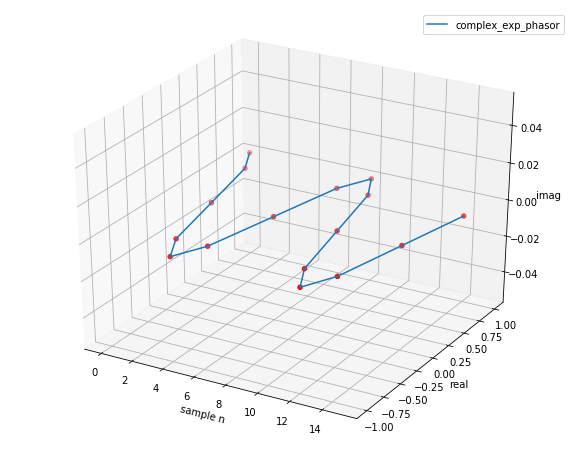

In [23]:
plt2d.show()
plt_polar.show()
plt_3d.show()

In [24]:
complex_vars = gen_W_signal(3, 0, 16) #k=3

#Relevant plots
complex_to_real_int = lambda x: list(map(lambda l: int(l.real), x))
samples_in_int = complex_to_real_int(complex_vars[: , 0])
plt2d = plot_2d_dtps(samples_in_int, complex_vars[:,1])
plt_polar = plot_polar_dtps(samples_in_int, complex_vars[:,1])
plt_3d = plot_3d_complex_plane(samples_in_int, complex_vars[:,1])
complex_vars[:10]

array([[  0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   3.82683432e-01,   9.23879533e-01],
       [  2.00000000e+00,  -7.07106781e-01,   7.07106781e-01],
       [  3.00000000e+00,  -9.23879533e-01,  -3.82683432e-01],
       [  4.00000000e+00,  -1.83697020e-16,  -1.00000000e+00],
       [  5.00000000e+00,   9.23879533e-01,  -3.82683432e-01],
       [  6.00000000e+00,   7.07106781e-01,   7.07106781e-01],
       [  7.00000000e+00,  -3.82683432e-01,   9.23879533e-01],
       [  8.00000000e+00,  -1.00000000e+00,   3.67394040e-16],
       [  9.00000000e+00,  -3.82683432e-01,  -9.23879533e-01]])

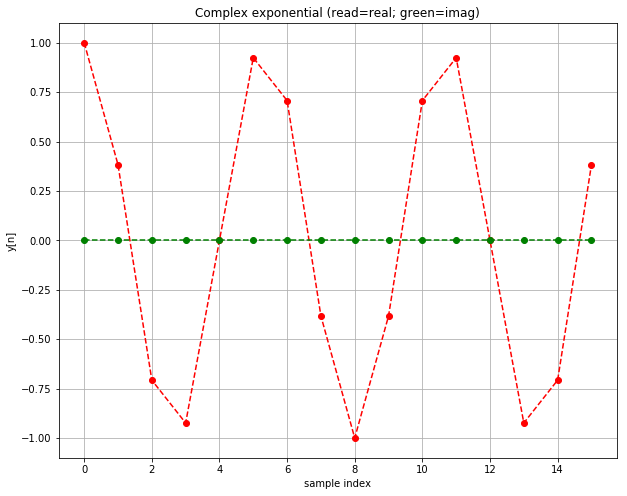

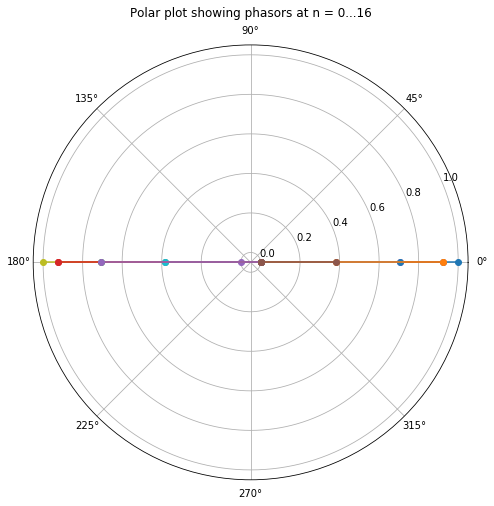

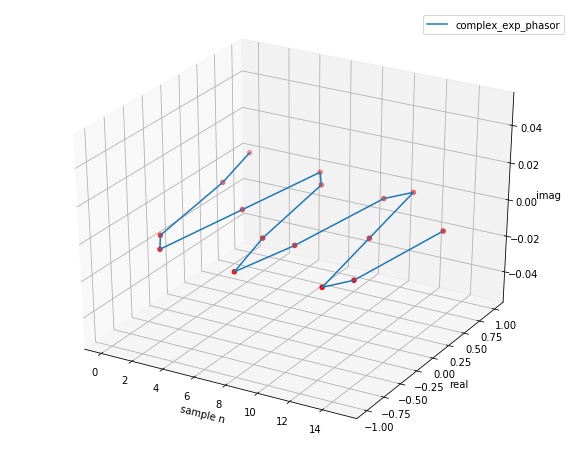

In [25]:
plt2d.show()
plt_polar.show()
plt_3d.show()